<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#implmentation" data-toc-modified-id="implmentation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>implmentation</a></span><ul class="toc-item"><li><span><a href="#1D" data-toc-modified-id="1D-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>1D</a></span></li><li><span><a href="#1-knot" data-toc-modified-id="1-knot-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>1 knot</a></span></li><li><span><a href="#2-knots" data-toc-modified-id="2-knots-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>2 knots</a></span></li><li><span><a href="#3-knots" data-toc-modified-id="3-knots-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>3 knots</a></span></li></ul></li><li><span><a href="#2D-fit" data-toc-modified-id="2D-fit-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>2D fit</a></span><ul class="toc-item"><li><span><a href="#1-knot" data-toc-modified-id="1-knot-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>1 knot</a></span></li></ul></li><li><span><a href="#2x2-knots" data-toc-modified-id="2x2-knots-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>2x2 knots</a></span><ul class="toc-item"><li><span><a href="#first-four-basis" data-toc-modified-id="first-four-basis-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>first four basis</a></span></li></ul></li><li><span><a href="#5Dfit" data-toc-modified-id="5Dfit-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>5Dfit</a></span><ul class="toc-item"><li><span><a href="#obviously-over-fit,-have-so-many-basis,-set-alpha->-0-for-a-better-result" data-toc-modified-id="obviously-over-fit,-have-so-many-basis,-set-alpha->-0-for-a-better-result-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>obviously over fit, have so many basis, set alpha &gt; 0 for a better result</a></span></li></ul></li></ul></div>

# implmentation

In [1]:
import numpy as np

class QuadraticSplineRegression:
    
    def __init__(self, knots, alpha=1E-6):
        if alpha is None:
            alpha = 1E-6
        self.alpha = alpha
        
        assert knots is not None
            
        all_is_scalar=True
        all_is_list=True
        for item in knots:
            all_is_scalar = all_is_scalar and np.isscalar(item)
            all_is_list = all_is_list and np.ndim(item) == 1
            
        if all_is_scalar:
            if len(knots) < 1:
                raise Exception("At lease one knot")
            knots = np.array(knots).reshape(1,-1)
        elif all_is_list:
            pass
        else:
            raise Exception('''1d array or 2d array knots needed, format: [xi0, xi1, ...] or \
                [[xi00, xi01, ...],\
                [xi10, xi11, ..],\
                ...]''')
        
        self.knots = knots
        
        
        # h0(x) = 1
        # h1(x) = x     
        # if N_hnots >= 2
            # i >= 0 && i+1 <= N_hnots-1
            # h(2+i)(x) = (x-xi_i)_+^2+ - (x-xi_(i+1))_+^2
            # h(2+i)(x) = 0,  x <  x_i
            #             (x-xi_i)^2,   xi_i < x < xi_i+1
            #             (x_(i+1)-x_i)(2x - x_i - xi_(i+1)), xi_i+1 < x
        self.N_splines = QuadraticSplineRegression.cal_N_splines(knots)
        #print("splines%d:", self.N_splines)
        
    @staticmethod
    def cal_N_splines(knots):
        N_splines = 1
        for knots_1D in knots:
            N_knots_1D = len(knots_1D)
            assert N_knots_1D >= 1            
            N_splines_1D = N_knots_1D + 1
            N_splines *= N_splines_1D
        
        return N_splines
    
    def get_H(self, X):
        knots = self.knots
        Ndata = X.shape[0]
        
        N_splines = self.N_splines
        
        #print("N_splines", N_splines)
        #print("Ndata", Ndata)
                
        H = np.ones((N_splines, Ndata))
        
        dim_in = 1
        for d in range(X.shape[1]):
            x = X[:, d]
            knots_1D = knots[d]
            N_knots_1D = len(knots_1D)
            assert N_knots_1D >= 1
            
            N_splines_1D = N_knots_1D + 1
            
            h = np.zeros((N_splines_1D, Ndata))

            #print("knots_1D:", knots_1D)
            #print("N_splines_1D:", N_splines_1D)
            knots_1D = np.sort(knots_1D)
            xi_max = np.max(knots_1D)
            
            h[0,:] = 1
            h[1,:] = x
            for i in range(2, N_splines_1D):
                xi = knots_1D[i-2]
                xiplus1 = knots_1D[i-1]
                h[i, :] = np.where(x < xi, 0.0,\
                                np.where(x < xiplus1,  (x-xi)**2, (xiplus1-xi)*(2*x - xi - xiplus1)  )) 
                assert xiplus1 - xi > 0
                assert 2*xi_max - xi - xiplus1 > 0
                h[i, :] /= (xiplus1 - xi)*(2*xi_max - xi - xiplus1)
                    
            # H[i][j][k] = h1[i]h2[j]h3[k]
            # H[i*JK + j*K + k] = h1[i]h2[j]h3[k]
            # H[i*JK+ j*stride + offset] = ... h2[j]...            
            dim_out =  N_splines//N_splines_1D//dim_in
            #print("d", d)
            #print("N_splines", N_splines)
            #print("dim_in", dim_in)
            #print("N_splines_1D", N_splines_1D)
            H = np.reshape(H, (dim_out, N_splines_1D, dim_in, Ndata))
            H[:,:,:,:] *= h[:,np.newaxis,:]
                
            dim_in *= N_splines_1D
            
        H = H.reshape(-1, Ndata).transpose()
        return H
    
        
    def fit(self, X, y):
        alpha = self.alpha
        knots = self.knots
        
        X = np.array(X, dtype=np.float_)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        if np.shape(knots)[0] != X.shape[1]:
            raise Exception("dimension of knots not match %d != %d"%(np.shape(knots)[0], X.shape[1]))

            
        y = np.array(y, dtype=np.float_)
        assert np.ndim(y) == 1
        
        Ndata = np.shape(X)[0] 
        H = self.get_H(X)
        
        # remove bias term        
        # we will handle it by ourselves
        H =  H[:, 1:]
        
        # center data
        y_mean = np.mean(y)
        y -= y_mean
        H_mean = np.mean(H, axis=0)
        H -= H_mean

        # needed for L2 regularization
        # but this don't work
        #H_scale = 1/np.sqrt(H.var(axis=0))
        #H = H_scale*H        
        #self.H_scale = H_scale
        
        
        # H[:,0] is special, no L2 applied on it
        
        # now we fit
        #   sum_j (y_j - sum_i H_i(X_j) beta_i)^2 + alpha sum_i beta_i^2
        #   U S VT = H_i
        #   beta_i = V (alpha*I + S^T S)^-1 S^T U y
        
        if H.shape[0] == 1 and False:
            # only 1 row
            norm = np.sqrt(np.square(H).sum())
            U=H/norm
            D=np.array(norm)
            VT=np.array([[1]])
        else:
            U,D,VT = np.linalg.svd(H, full_matrices=False)
        lamb = alpha*Ndata
        invD = D/(np.square(D) + lamb)            
        beta = VT.T.dot((invD * U.T.dot(y)))
        
        # bias calculate here, not by fit
        self.bias = y_mean - H_mean.dot(beta)
        self.beta = beta
        
    def predict(self, X):
        knots = self.knots
        
        X = np.array(X, dtype=np.float_)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
            
        if np.shape(knots)[0] != X.shape[1]:
            raise Exception("dimension of knots not match %d != %d"%(np.shape(knots)[0], X.shape[1]))
        
        #   y = sum_i H_i(x) beta_i + b
        H = self.get_H(X)
        # we don't need this
        H =  H[:, 1:]
        #H = self.H_scale * H
        yhat = H.dot(self.beta) + self.bias
        return yhat
    
    
    


## 1D

## 1 knot

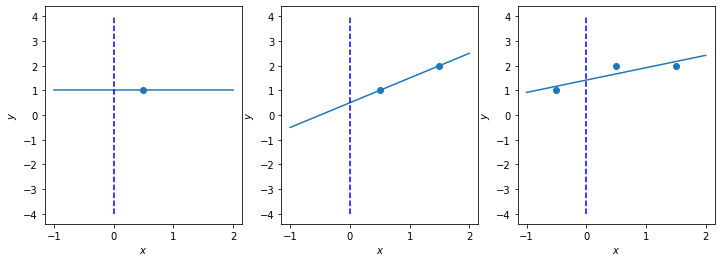

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def fit_plot(X_train, y_train, knots, xlim, ax):    
    X_plt = np.linspace(xlim[0], xlim[1], 100)
    reg = QuadraticSplineRegression(knots=knots)
    reg.fit(X_train, y_train)
    ax.scatter(X_train, y_train)
    ax.plot(X_plt, reg.predict(X_plt))
    #print(reg.beta)
    #print(reg.bias)
    for knot in knots:
        ax.plot([knot, knot],[-4,4], linestyle="--", color="blue")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    
    
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))
fit_plot(X_train = [0.5], y_train = [1], xlim=(-1,2), knots=[0], ax=ax1)
fit_plot(X_train = [0.5, 1.5], y_train = [1,2], xlim=(-1,2), knots=[0], ax=ax2)
fit_plot(X_train = [-0.5, 0.5, 1.5], y_train = [1,2,2], xlim=(-1,2), knots=[0], ax=ax3)
plt.show()

## 2 knots

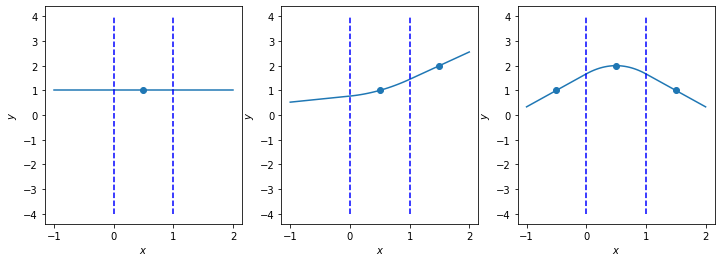

In [3]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))
fit_plot(X_train = [0.5], y_train = [1], xlim=(-1,2), knots=[0,1], ax=ax1)
fit_plot(X_train = [0.5, 1.5], y_train = [1,2], xlim=(-1,2), knots=[0,1],ax=ax2)
fit_plot(X_train = [-0.5, 0.5, 1.5], y_train = [1,2,1], xlim=(-1,2), knots=[0,1],ax=ax3)
plt.show()

## 3 knots

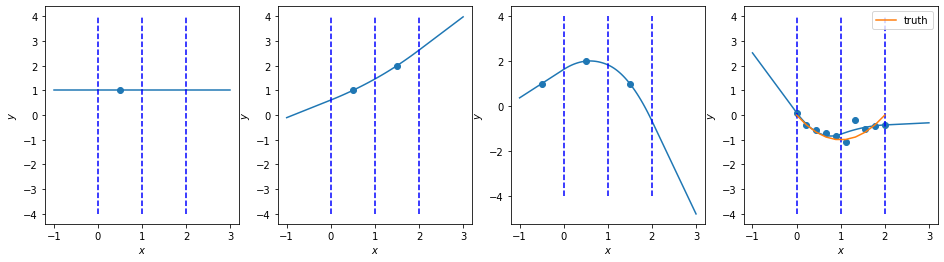

In [4]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(16,4))
fit_plot(X_train = [0.5], y_train = [1], xlim=(-1,3), knots=[0,1,2], ax=ax1)
fit_plot(X_train = [0.5, 1.5], y_train = [1,2], xlim=(-1,3), knots=[0,1,2],ax=ax2)
fit_plot(X_train = [-0.5, 0.5, 1.5], y_train = [1,2,1], xlim=(-1,3), knots=[0,1,2],ax=ax3)
X=np.linspace(0,2,10)
y=X*X-2*X
fit_plot(X_train = X, y_train=y+0.2*np.random.randn(10), xlim=(-1,3), knots=[0,1,2],ax=ax4)
ax4.plot(X, y, label="truth")
plt.legend(loc="upper right")
plt.show()

# 2D fit

## 1 knot

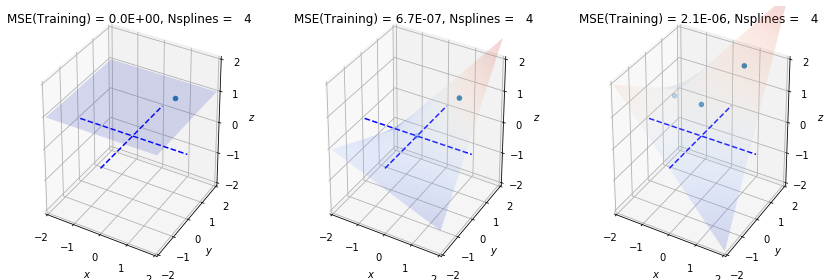

In [5]:
from mpl_toolkits.mplot3d.axes3d import get_test_data

def fit_plot3d(X_train, y_train, knots, xlim=(-2,2), ylim=(-2,2), zlim=(-2,2), ax=None, sz=20, alpha=None):    
    X_train = np.array(X_train)
    
    x_plt = np.linspace(xlim[0], xlim[1], 100)
    y_plt = np.linspace(ylim[0], ylim[1], 100)
    xx, yy = np.meshgrid(x_plt, y_plt)
    reg = QuadraticSplineRegression(knots=knots, alpha=alpha)
    reg.fit(X_train, y_train)
    #print(reg.beta)
    #print(reg.bias)
    ax.scatter(X_train[:,0], X_train[:,1], y_train, s=sz)
    
    from matplotlib import cm
    ax.plot_surface(xx, yy, reg.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(100,100), alpha=0.2, cmap=cm.coolwarm)
    
    for k1 in knots[0]:
        ax.plot([k1, k1],[-2,2],[0,0], linestyle="--", color="blue")
    for k2 in knots[1]:
        ax.plot([-2, 2],[k2, k2],[0,0], linestyle="--", color="blue")
        
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_zlabel("$z$")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    mse = np.sqrt(np.square(y_train-reg.predict(X_train)).mean())
    ax.set_title("MSE(Training) = %.1E, Nsplines = %3d"%(mse, reg.N_splines))
    
    return reg

    
fig=plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,3,1, projection="3d")
fit_plot3d(X_train = [[1,1]], y_train = [1], xlim=(-2,2), knots=[[0],[0]], ax=ax1)
ax2 = fig.add_subplot(1,3,2, projection="3d")
fit_plot3d(X_train = [[0,0], [1,1]], y_train = [0, 1], xlim=(-2,2), knots=[[0],[0]], ax=ax2)
ax3 = fig.add_subplot(1,3,3, projection="3d")
fit_plot3d(X_train = [[-1,0], [0,0], [1,1]], y_train = [1, 1, 2], xlim=(-2,2), knots=[[0],[0]], ax=ax3)
plt.tight_layout()
plt.show()


# 2x2 knots

## first four basis

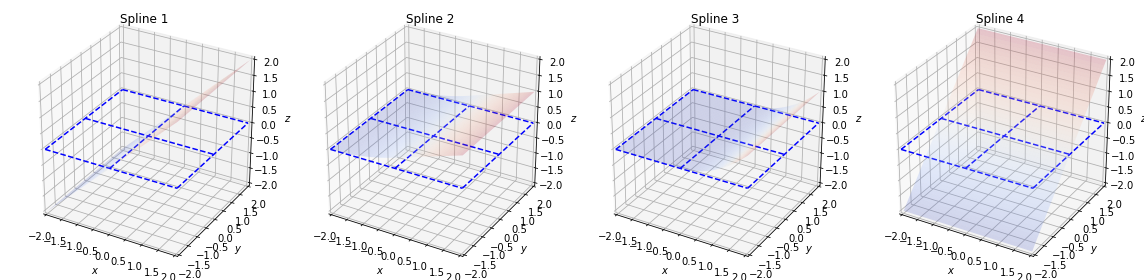

In [6]:
def fit_plot3d_i(knots, i, xlim=(-2,2), ylim=(-2,2), zlim=(-2,2), ax=None, sz=20, alpha=None):    
    
    x_plt = np.linspace(xlim[0], xlim[1], 100)
    y_plt = np.linspace(ylim[0], ylim[1], 100)
    xx, yy = np.meshgrid(x_plt, y_plt)
    reg = QuadraticSplineRegression(knots=knots, alpha=alpha)
    #beta = reg.beta[i]
    reg.beta = np.zeros(reg.N_splines-1)
    reg.beta[i] = 1
    reg.bias=0
    #print(reg.beta)
    #print(reg.bias)
    
    from matplotlib import cm
    ax.plot_surface(xx, yy, reg.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(100,100), alpha=0.2, cmap=cm.coolwarm)
    
    for k1 in knots[0]:
        ax.plot([k1, k1],[-2,2],[0,0], linestyle="--", color="blue")
    for k2 in knots[1]:
        ax.plot([-2, 2],[k2, k2],[0,0], linestyle="--", color="blue")
        
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_zlabel("$z$")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    ax.set_title("Spline %d"%(i+1))
    
    return reg



fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1,4,1, projection="3d")
reg = fit_plot3d_i(i=0, zlim=(-2,2), knots=[np.linspace(-2,2,3)]*2, ax=ax1, sz=10)
ax2 = fig.add_subplot(1,4,2, projection="3d")
reg = fit_plot3d_i(i=1,  zlim=(-2,2), knots=[np.linspace(-2,2,3)]*2, ax=ax2, sz=10)
ax3 = fig.add_subplot(1,4,3, projection="3d")
reg = fit_plot3d_i(i=2, zlim=(-2,2), knots=[np.linspace(-2,2,3)]*2, ax=ax3, sz=10)
ax4 = fig.add_subplot(1,4,4, projection="3d")
reg = fit_plot3d_i(i=3, zlim=(-2,2), knots=[np.linspace(-2,2,3)]*2, ax=ax4, sz=10)
plt.tight_layout()
plt.show()


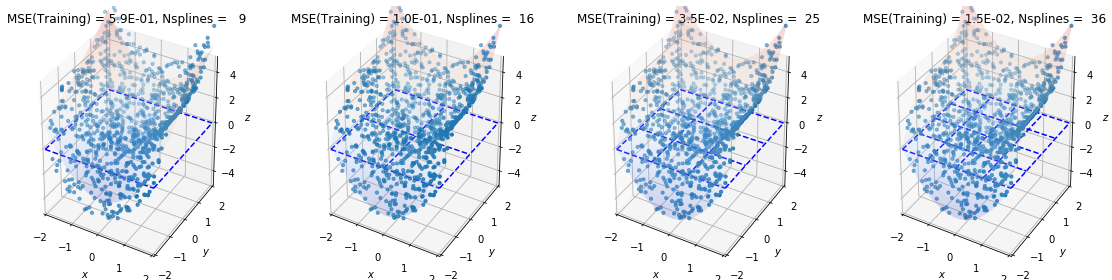

In [7]:
X_train=4*np.random.rand(1000, 2)-2
y_train=  X_train[:,0]*X_train[:,0] + 1/2*X_train[:,1]**3 + 0*np.random.randn(X_train.shape[0])

fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1,4,1, projection="3d")
reg = fit_plot3d(X_train = X_train, y_train = y_train, zlim=(-5,5), knots=[np.linspace(-2,2,2)]*2, ax=ax1, sz=10)
ax2 = fig.add_subplot(1,4,2, projection="3d")
reg = fit_plot3d(X_train = X_train, y_train = y_train, zlim=(-5,5), knots=[np.linspace(-2,2,3)]*2, ax=ax2, sz=10)
ax3 = fig.add_subplot(1,4,3, projection="3d")
reg = fit_plot3d(X_train = X_train, y_train = y_train, zlim=(-5,5), knots=[np.linspace(-2,2,4)]*2, ax=ax3, sz=10)
ax4 = fig.add_subplot(1,4,4, projection="3d")
reg = fit_plot3d(X_train = X_train, y_train = y_train, zlim=(-5,5), knots=[np.linspace(-2,2,5)]*2, ax=ax4, sz=10)
plt.tight_layout()
plt.show()


# 5Dfit

## obviously over fit, have so many basis, set alpha > 0 for a better result

No. of splines  1024
No. of Points  4608


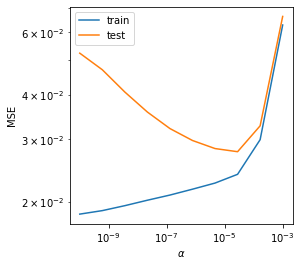

In [8]:
N=5
def f6(X):
    return X[:,0] + X[:,1]**3   \
    + 0.25*1/(1+0.2*X[:,2]) + 0.25*1/(1+0.3*X[:,3])/(1+0.3*X[:,4])


X = 2 * np.random.rand(3*3*8*8*8, N) - 1
y = f6(X) + 0.0 * np.random.randn(3*3*8*8*8)

X_train = X[0::2,:]
y_train = y[0::2]
X_test = X[1::2,:]
y_test = y[1::2]

mse_train=[]
mse_test=[]
alphas=np.power(10, np.linspace(-10, -3, 10))
for alpha in alphas:
    qsr = QuadraticSplineRegression(knots=[np.linspace(-1,1,3)]*N, alpha=alpha)
    qsr.fit(X_train, y_train)
    mse_test.append(np.sqrt(np.square(y_test - qsr.predict(X_test)).mean()))
    mse_train.append(np.sqrt(np.square(y_train - qsr.predict(X_train)).mean()))
      
print("No. of splines ", qsr.N_splines)
print("No. of Points ", X.shape[0])
plt.figure(figsize=(4,4))
plt.plot(alphas, mse_train, label="train")
plt.plot(alphas, mse_test, label="test")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\alpha$")
plt.ylabel("MSE")
plt.legend()
plt.show()